In [1]:
import os
import sys
sys.path.append(os.pardir)
from dataset import ptb

import numpy as np
import matplotlib.pyplot as plt
from simpleDL.model import *
from simpleDL.function_class import *
from simpleDL.function import *
from simpleDL.data import *
from simpleDL.optimizer import *
from simpleDL.trainer import *
np.random.seed(0)

In [2]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

말뭉치 크기: 1000, 어휘 수: 418


In [3]:
model = Model(
    EmbeddingLayer(vocab_size, 100),
    RNNLayer(100, 100),
    DenseLayer(100, vocab_size)
)

In [4]:
print(model)

0. EmbeddingLayer1 : EmbeddingLayer (418, 100) 
1. RNNLayer1 : RNNLayer (100, 100) 
2. DenseLayer1 : DenseLayer (100, 418) 



In [5]:
critic = CrossEntropyLoss()
optim = SGDOptimizer(lr = 0.1)

In [6]:
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
max_epoch = 100
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []


[[[ 0.01022905 -0.02887725  0.07055897 ...  0.11655214  0.19662067
   -0.00627034]
  [-0.21639782 -0.07819558 -0.40922305 ... -0.06302092 -0.08258689
    0.18128919]
  [-0.02816479 -0.62069177  0.58348131 ...  0.0526052   0.41019044
    0.44119075]
  [-0.50665405  0.37788935 -0.21712512 ...  0.10880163 -0.36619643
   -0.08422249]
  [ 0.37035928 -0.23209797 -0.5730139  ...  0.03218712 -0.00803016
   -0.64068414]]

 [[ 0.02014944  0.27610173  0.02562756 ... -0.06567041  0.18636407
    0.14344697]
  [-0.22660659  0.14088441 -0.0182384  ... -0.10113547  0.39919301
    0.20409472]
  [ 0.06182503 -0.22994276 -0.59565225 ... -0.43981936 -0.08151882
    0.16492344]
  [ 0.56842021 -0.02056158  0.76041924 ... -0.15767881 -0.01247627
    0.49724557]
  [ 0.63824817 -0.29760862  0.26227424 ...  0.09339873 -0.54150319
   -0.23300759]]

 [[ 0.00939129  0.04674318  0.25128927 ...  0.03606208  0.03482986
    0.15041257]
  [ 0.19022007  0.08674387  0.13739258 ... -0.05174716  0.24523192
    0.25239457]


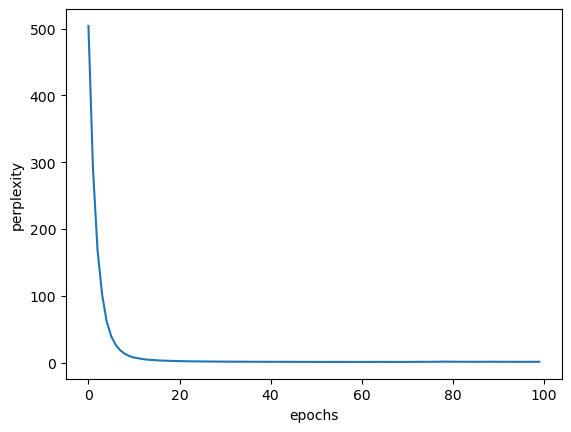

In [7]:
jump = (len(corpus) - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        pred = model(batch_x)
        print(pred)
        loss = critic(pred, batch_t)
        print(loss)
        model._backward(critic)
        optim.update(model)
        total_loss += loss
        loss_count += 1
    print()
    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

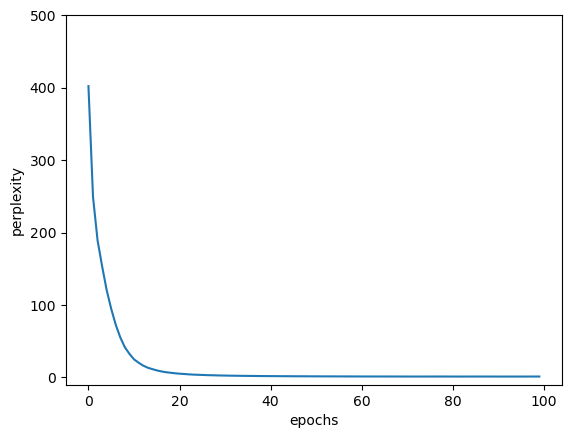

In [8]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.ylim(-10, 500)
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()